# Download and process sentinel 2 data

## John Brandt
## April 1, 2020

## Package imports, API import, source scripts

In [1]:
import datetime
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import scipy.sparse as sparse
import seaborn as sns
import yaml

from collections import Counter
from osgeo import ogr, osr
from random import shuffle
from scipy.sparse.linalg import splu
from s2cloudless import S2PixelCloudDetector, CloudMaskRequest
from sentinelhub import WmsRequest, WcsRequest, MimeType
from sentinelhub import CRS, BBox, constants, DataSource, CustomUrlParam
from skimage.transform import resize

with open("../config.yaml", 'r') as stream:
        key = (yaml.safe_load(stream))
        API_KEY = key['key'] 
        
%matplotlib inline
%run ../src/utils/slope.py
%run ../src/utils/utils-bilinear.py
%run ../src/dsen2/utils/DSen2Net.py

/Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


## Parameters

In [2]:
# Parameters
SUPER_RESOLVE = True
YEAR = 2019
TIME = ('{}-12-15'.format(str(YEAR - 1)), '{}-01-15'.format(str(YEAR + 1)))
EPSG = CRS.WGS84
IMSIZE = 48
CLOUD_DETECTOR = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2)
DATA_LOCATION = '../data/ghana-test.csv'
OUTPUT_FOLDER = '../data/test-smooth-200/'

# For DSen2 superresolve
MDL_PATH = "../src/dsen2/models/"
INPUT_SHAPE = ((4, None, None), (6, None, None))
MODEL = s2model(INPUT_SHAPE, num_layers=6, feature_size=128)
PREDICT_FILE = MDL_PATH+'s2_032_lr_1e-04.hdf5'
MODEL.load_weights(PREDICT_FILE)

# Constants
starting_days = np.cumsum([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30])
c_arr = np.array([[1, 1, 1, 1, 1,],
                  [1, 2, 2, 2, 1,],
                  [1, 2, 3, 2, 1,],
                  [1, 2, 2, 2, 1,],
                  [1, 1, 1, 1, 1,],])
                  
c_arr = c_arr / 3
o_arr = 1 - c_arr
c_arr = np.tile(c_arr[:, :, np.newaxis], (1, 1, 11))
o_arr = np.tile(o_arr[:, :, np.newaxis], (1, 1, 11))

# Helper functions

In [3]:
def calculate_proximal_steps_index(date, satisfactory):
    """Returns proximal steps that are cloud and shadow free

         Parameters:
          date (int): current time step
          satisfactory (list): time steps with no clouds or shadows

         Returns:
          arg_before (str): index of the prior clean image
          arg_after (int): index of the next clean image
    """
    arg_before, arg_after = None, None
    if date > 0:
        idx_before = satisfactory - date
        arg_before = idx_before[np.where(idx_before < 0, idx_before, -np.inf).argmax()]
    if date < np.max(satisfactory):
        idx_after = satisfactory - date
        arg_after = idx_after[np.where(idx_after > 0, idx_after, np.inf).argmin()]
    if not arg_after and not arg_before:
        arg_after = date
        arg_before = date
    if not arg_after:
        arg_after = arg_before
    if not arg_before:
        arg_before = arg_after
    return arg_before, arg_after

def speyediff(N, d, format = 'csc'):
    """Calculates the d-th order sparse difference matrix based on 
       an initial N x N identity matrix

         Parameters:
          N (int): input length
          d (int): smoothing order

         Returns:
          spmat (arr): sparse difference matrix
    """
    shape = (N-d, N)
    diagonals = np.zeros(2*d + 1)
    diagonals[d] = 1.
    for i in range(d):
        diff = diagonals[:-1] - diagonals[1:]
        diagonals = diff
    offsets = np.arange(d+1)
    spmat = sparse.diags(diagonals, offsets, shape, format = format)
    return spmat

def smooth(y, lmbd, d = 2):
    """Calculates the whittaker smoother on input array

         Parameters:
          y (arr): 1-dimensional input array
          lmbd (int): degree of smoothing, higher is more

         Returns:
          z (arr): smoothed version of y
    """
    m = len(y)
    E = sparse.eye(m, format = 'csc')
    D = speyediff(m, d, format = 'csc')
    coefmat = E + lmbd * D.conj().T.dot(D)
    z = splu(coefmat).solve(y)
    return z

def DSen2(d10, d20):
    """Super resolves 20 meter bans using the DSen2 convolutional
       neural network, as specified in Lanaras et al. 2018
       https://github.com/lanha/DSen2

        Parameters:
         d10 (arr): (4, X, Y) shape array with 10 meter resolution
         d20 (arr): (6, X, Y) shape array with 20 meter resolution

        Returns:
         prediction (arr): (6, X, Y) shape array with 10 meter superresolved
                          output of DSen2 on d20 array
    """
    test = [d10, d20]
    input_shape = ((4, None, None), (6, None, None))
    prediction = _predict(test, input_shape, deep=False)
    return prediction

def _predict(test, input_shape, model = MODEL, deep=False, run_60=False):
    
    prediction = model.predict(test, verbose=1)
    return prediction

# Bounding boxes

In [142]:
def convertCoords(xy, src='', targ=''):
    """ Converts coords from one EPSG to another

        Parameters:
         xy (tuple): input longitiude, latitude tuple
         src (str): EPSG code associated with xy
         targ (str): EPSG code of target output
    
        Returns:
         pt (tuple): (x, y) tuple of xy in targ EPSG
    """

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

def calculate_epsg(points):
    """ Calculates the UTM EPSG of an input WGS 84 lon, lat

        Parameters:
         points (tuple): input longitiude, latitude tuple
    
        Returns:
         epsg_code (int): integer form of associated UTM EPSG
    """
    lon, lat = points[0], points[1]

    utm_band = str((math.floor((lon + 180) / 6 ) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0'+utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return int(epsg_code)
    

def calc_bbox(plot_id, df):
    """ Calculates the corners of a bounding box from an input
        pandas dataframe as output by Collect Earth Online

        Parameters:
         plot_id (int): plot_id of associated plot
         df (pandas.DataFrame): dataframe of associated CEO survey
    
        Returns:
         bounding_box (list): [(min(x), min(y)),
                              (max(x), max_y))]
    """
    subs = df[df['PLOT_ID'] == plot_id]
    # TOP, LEFT, BOTTOM, RIGHT
    # (min x, min y), (max x, max y)
    return [(min(subs['LON']), min(subs['LAT'])),
            (max(subs['LON']), max(subs['LAT']))]

def bounding_box(points, expansion = 160):
    """ Calculates the corners of a bounding box with an
        input expansion in meters from a given bounding_box
        
        Subcalls:
         calculate_epsg, convertCoords

        Parameters:
         points (list): output of calc_bbox
         expansion (float): number of meters to expand or shrink the
                            points edges to be
    
        Returns:
         bl (tuple): x, y of bottom left corner with edges of expansion meters
         tr (tuple): x, y of top right corner with edges of expansion meters
    """
    # This must be lon, lat
    bl = list(points[0])
    tr = list(points[1])
    
    epsg = calculate_epsg(bl)
    bl = convertCoords(bl, 4326, epsg)
    tr = convertCoords(tr, 4326, epsg)
    init = [b - a for a,b in zip(bl, tr)]
    distance1 = tr[0] - bl[0]
    distance2 = tr[1] - bl[1]
    expansion1 = (expansion - distance1)/2
    expansion2 = (expansion - distance2)/2
    bl = [bl[0] - expansion1, bl[1] - expansion2]
    tr = [tr[0] + expansion1, tr[1] + expansion2]

    after = [b - a for a,b in zip(bl, tr)]   
    diffs = [b - a for b, a in zip(after, init)]

    bl = convertCoords(bl, epsg, 4326)
    tr = convertCoords(tr, epsg, 4326)
    return bl, tr

# Data download

In [169]:
def rank_array(arr):
    order = arr.argsort()
    ranks = order.argsort()
    return ranks

def mcm_shadow_mask(arr, c_probs):
    """ Calculates the multitemporal shadow mask for Sentinel-2 using
        the methods from Candra et al. 2020 on L1C images and matching
        outputs to the s2cloudless cloud probabilities

        Parameters:
         arr (arr): (Time, X, Y, Band) array of L1C data scaled from [0, 1]
         c_probs (arr): (Time, X, Y) array of S2cloudless cloud probabilities
    
        Returns:
         shadows_new (arr): cloud mask after Candra et al. 2020 and cloud matching 
         shadows_original (arr): cloud mask after Candra et al. 2020
    """
    mean_c_probs = np.mean(c_probs, axis = (1, 2))
    cloudy_steps = np.argwhere(mean_c_probs > 0.25)
    images_clean = np.delete(arr, cloudy_steps, 0)
    cloud_ranks = rank_array(mean_c_probs)
    diffs = abs(np.sum(arr - np.mean(images_clean, axis = 0), axis = (1, 2, 3)))
    diff_ranks = rank_array(diffs)
    overall_rank = diff_ranks + cloud_ranks
    reference_idx = np.argmin(overall_rank)
    ri = arr[reference_idx]
    print("The shadow reference index is: {}".format(reference_idx))
    
    shadows = np.zeros((arr.shape[0], 96, 96))    
    # Candra et al. 2020
    
    for time in range(arr.shape[0]):
        for x in range(arr.shape[1]):
            for y in range(arr.shape[2]):
                ti_slice = arr[time, x, y]
                ri_slice = ri[x, y]
                deltab2 = ti_slice[0] - ri_slice[0]
                #deltab3 = ti_slice[2] - ri_slice[2]
                #deltab4 = ti_slice[3] - ri_slice[3]
                deltab8a = ti_slice[1] - ri_slice[1]
                deltab11 = ti_slice[2] - ri_slice[2]

                if deltab2 <0.1: #(1000/65535):
                    #if deltab3 < (800/65535)
                        #if deltab4 < (800/65535)
                    if deltab8a < -0.04: # (-400/65535):
                        if deltab11 < -0.04: ##(-400/65535):
                            if ti_slice[0] < 0.095: #(950/65535):
                                shadows[time, x, y] = 1.
                                        
    shadows_original = np.copy(shadows)
    # Remove shadows if cannot coreference a cloud
    print(shadows.shape)
    shadow_large = np.reshape(shadows, (shadows.shape[0], 96//8, 8, 96//8, 8))
    shadow_large = np.sum(shadow_large, axis = (2, 4))
    
    cloud_large = np.copy(c_probs)
    cloud_large[np.where(c_probs > 0.33)] = 1.
    cloud_large[np.where(c_probs < 0.33)] = 0.
    cloud_large = np.reshape(cloud_large, (shadows.shape[0], 96//8, 8, 96//8, 8))
    cloud_large = np.sum(cloud_large, axis = (2, 4))
    for time in range(shadow_large.shape[0]):
        for x in range(shadow_large.shape[1]):
            x_low = np.max([x - 8, 0])
            x_high = np.min([x + 8, shadow_large.shape[1] - 1])
            for y in range(shadow_large.shape[2]):
                y_low = np.max([y - 8, 0])
                y_high = np.min([y + 8, shadow_large.shape[1] - 1])
                if shadow_large[time, x, y] < 8:
                    shadow_large[time, x, y] = 0.
                if shadow_large[time, x, y] >= 8:
                    shadow_large[time, x, y] = 1.
                c_prob_window = cloud_large[time, x_low:x_high, y_low:y_high]
                if np.max(c_prob_window) < 24:
                    shadow_large[time, x, y] = 0.
                    
    
    shadow_large = resize(shadow_large, (shadow_large.shape[0], 96, 96), order = 0)
    shadows *= shadow_large
    
    # Go through and aggregate the shadow map to an 80m grid, and extend it one grid size around
    # any positive ID
    
    
    shadows = np.reshape(shadows, (shadows.shape[0], 96//8, 8, 96//8, 8))
    shadows = np.sum(shadows, axis = (2, 4))
    shadows[np.where(shadows < 16)] = 0.
    shadows[np.where(shadows >= 16)] = 1.
    shadows = resize(shadows, (shadows.shape[0], 96, 96), order = 0)
    shadows = np.reshape(shadows, (shadows.shape[0], 96//4, 4, 96//4, 4))
    shadows = np.max(shadows, (2, 4))
    
    shadows_new = np.zeros_like(shadows)
    for time in range(shadows.shape[0]):
        for x in range(shadows.shape[1]):
            for y in range(shadows.shape[2]):
                if shadows[time, x, y] == 1:
                    min_x = np.max([x - 1, 0])
                    max_x = np.min([x + 2, shadows.shape[1] - 1])
                    min_y = np.max([y - 1, 0])
                    max_y = np.min([y + 2, shadows.shape[1] - 1])
                    for x_idx in range(min_x, max_x):
                        for y_idx in range(min_y, max_y):
                            shadows_new[time, x_idx, y_idx] = 1.
    shadows_new = resize(shadows_new, (shadows.shape[0], 96, 96), order = 0)
    print("The shadow probability is: {}".format(100*np.sum(shadows_new)/(96*96*shadows_new.shape[0])))
    return np.array(shadows_new)

def identify_clouds(bbox, epsg = EPSG, time = TIME, cloud_detector = CLOUD_DETECTOR,
                    image_format =  MimeType.TIFF_d16):
    """ Calculates the cloud probabilities of L1C Sentinel-2 data with
        the S2Cloudless light GBM

        Parameters:
         bbox (list): output of calc_bbox
         epsg (float): number 
         time (float): number 
         cloud_detector (obj): 
    
        Returns:
         cloud_probs (arr)
         shadows (arr)
         shadow_original (arr)
         cloud_probs (arr)
    """
    box = BBox(bbox, crs = epsg)
    cloud_request = WmsRequest(
        layer='CLOUD_DETECTION',
        bbox=box,
        time=time,
        width=96,
        height=96,
        image_format = image_format,
        maxcc=0.75,
        instance_id=API_KEY,
        custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
        time_difference=datetime.timedelta(hours=48),
    )

    cloud_img = cloud_request.get_data()
    print("Bef", np.max(cloud_img))
    if image_format == MimeType.TIFF_d16:
        cloud_img = np.array(cloud_img) / 65535
    print("Aft cl", np.max(cloud_img))
    cloud_probs = cloud_detector.get_cloud_probability_maps(np.array(cloud_img))
    shadows, shadow_original = mcm_shadow_mask(np.array(cloud_img), cloud_probs)
    print(shadows.shape)
    print(type(shadows))
    shadows = np.array(shadows)[:, 24:-24, 24:-24]
    return cloud_probs[:, 24:-24, 24:-24], shadows, shadow_original, cloud_probs
    #except Exception as e:
    #    logging.fatal(e, exc_info=True)
    
def identify_clouds_new(bbox, epsg = EPSG, time = TIME):

    for try_ in range(0, 5):
        try:
            box = BBox(bbox, crs = epsg)
            cloud_request = WmsRequest(
                layer='CLOUD_NEW',
                bbox=box,
                time=time,
                width=96,
                height=96,
                image_format =  MimeType.TIFF_d32f,
                maxcc=0.75,
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                time_difference=datetime.timedelta(hours=48))
            
            shadow_request = WmsRequest(
                layer='SHADOW',
                bbox=box,
                time=time,
                width=96,
                height=96,
                image_format =  MimeType.TIFF_d16,
                maxcc=0.75,
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                time_difference=datetime.timedelta(hours=48))

            cloud_img = cloud_request.get_data()
            cloud_img = np.array(cloud_img)
            cloud_probs = cloud_img / 255
            
            shadow_img = shadow_request.get_data()
            shadow_img = np.array(shadow_img)
            print(np.max(shadow_img))
            shadow_img = shadow_img / 65535
            print(np.max(shadow_img))
            
            shadows = mcm_shadow_mask(np.array(shadow_img), cloud_probs)
            shadows = shadows[:, 24:-24, 24:-24]
            return cloud_probs[:, 24:-24, 24:-24], shadows#, shadow_original, cloud_probs
        except Exception as e:
            logging.fatal(e, exc_info=True)
    
    
def download_dem(plot_id, df, epsg = EPSG, image_format = MimeType.TIFF_d32f):
    #! TODO: ensure that centroid vs. bbox is correctly distinguished
    """ Downloads MapZen digital elevation model and return slope

        Parameters:
         plot_id (tuple): plot id from collect earth online (CEO)
         df (pandas.DataFrame): data associated with plot_id from CEO
         epsg (int): UTM EPSG associated with plot_id
    
        Returns:
         slope (arr): (X, Y, 1) array of per-pixel slope from [0, 1]
    """
    location = calc_bbox(plot_id, df = df)
    bbox = bounding_box(location, expansion = (IMSIZE+2)*10)
    box = BBox(bbox, crs = epsg)
    dem_request = WmsRequest(data_source=DataSource.DEM,
                         layer='DEM',
                         bbox=box,
                         width=IMSIZE+2,
                         height=IMSIZE+2,
                         instance_id=API_KEY,
                         image_format= image_format,
                         custom_url_params={CustomUrlParam.SHOWLOGO: False})
    dem_image = dem_request.get_data()[0]
    slope = calcSlope(dem_image.reshape((1, IMSIZE+2, IMSIZE+2)),
                      np.full((IMSIZE+2, IMSIZE+2), 10),
                      np.full((IMSIZE+2, IMSIZE+2), 10), 
                      zScale = 1, minSlope = 0.02)
    slope = slope.reshape((IMSIZE+2, IMSIZE+2, 1))
    slope = slope[1:IMSIZE+1, 1:IMSIZE+1, :]
    print(slope.shape)
    return slope

def check_zenith(bbox, epsg = EPSG, time = TIME):
    """ Downloads the zenith layer from sentinel-hub so that
        if desired, the data can be subsetted by zenith angle
        
        Parameters:
         bbox (list): output of calc_bbox
         epsg (float): number 
         time (float): number 
    
        Returns:
         zenith (arr): (Time, X, Y) array of per-pixel zenith from [0, 1] 
    """
    try:
        box = BBox(bbox, crs = epsg)
        zenith = WmsRequest(
            layer='ZENITH',
            bbox=box,
            time=time,
            width=IMSIZE,
            height=IMSIZE,
            image_format = MimeType.TIFF_d16,
            maxcc=0.75,
            instance_id=API_KEY,
            custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
            time_difference=datetime.timedelta(hours=48),
        )
        
        zenith = zenith.get_data()
        return zenith
    except Exception as e:
        logging.fatal(e, exc_info=True)
        
def download_layer(bbox, epsg = EPSG, time = TIME, image_format = MimeType.TIFF_d16):
    """ Downloads the VV and VH gamma backscatter coefficient sentinel 1 data
        
        Parameters:
         bbox (list): output of calc_bbox
         epsg (float): UTM EPSG associated with bbox 
         time (tuple): YY-MM-DD - YY-MM-DD bounds for downloading 
    
        Returns:
         img (arr):
         img_request (obj): 
    """
    try:
        box = BBox(bbox, crs = epsg)
        image_request = WcsRequest(
                layer='L2A20',
                bbox=box,
                time=time,
                image_format = image_format,
                maxcc=0.75,
                resx='10m', resy='10m',
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'NEAREST',
                                    constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                time_difference=datetime.timedelta(hours=48),
            )
        img_bands = image_request.get_data()
        img_20 = np.stack(img_bands)
        img_20 = resize(img_20, (img_20.shape[0], IMSIZE, IMSIZE, img_20.shape[-1]), order = 0)
        
        image_request = WcsRequest(
                layer='L2A10',
                bbox=box,
                time=time,
                image_format = image_format,
                maxcc=0.75,
                resx='10m', resy='10m',
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'BICUBIC',
                                    constants.CustomUrlParam.UPSAMPLING: 'BICUBIC'},
                time_difference=datetime.timedelta(hours=48),
        )
        
        img_bands = image_request.get_data()
        img_10 = np.stack(img_bands)
        print("The original L2A image size is: {}".format(img_10.shape))
        img_10 = resize(img_10, (img_10.shape[0], IMSIZE, IMSIZE, img_10.shape[-1]), order = 0)
        img = np.concatenate([img_10, img_20], axis = -1)
        print(np.max(img))
        #if image_format == MimeType.TIFF_d16:
        #    img = np.array(img) / 65535
        return img, image_request

    except Exception as e:
        logging.fatal(e, exc_info=True)

# Cloud and shadow removal

In [170]:
def remove_cloud_and_shadows(tiles, probs, shadows, image_dates, wsize = 5):
    """ Interpolates clouds and shadows for each time step with 
        linear combination of proximal clean time steps for each
        region of specified window size
        
        Parameters:
         tiles (arr):
         probs (arr): 
         shadows (arr):
         image_dates (list):
         wsize (int): 
    
        Returns:
         tiles (arr): 
    """
    c_probs = np.copy(probs)
    c_probs = c_probs - np.min(c_probs, axis = 0)
    c_probs[np.where(c_probs > 0.33)] = 1.
    c_probs[np.where(c_probs < 0.33)] = 0.
    c_probs = np.reshape(c_probs, [c_probs.shape[0], int(IMSIZE/8), 8, int(IMSIZE/8), 8])
    c_probs = np.sum(c_probs, (2, 4))
    c_probs = resize(c_probs, (c_probs.shape[0], IMSIZE, IMSIZE), 0)
    c_probs[np.where(c_probs < 12)] = 0.
    c_probs[np.where(c_probs >= 12)] = 1.
    c_probs += shadows
    c_probs[np.where(c_probs >= 1.)] = 1.
    n_interp = 0
    for cval in range(0, IMSIZE - 5, 1):
        for rval in range(0, IMSIZE - 5, 1):
            subs = c_probs[:, cval:cval + wsize, rval:rval+wsize]
            satisfactory = [x for x in range(c_probs.shape[0]) if np.sum(subs[x, :, :]) < 10]
            satisfactory = np.array(satisfactory)
            for date in range(0, tiles.shape[0]):
                if np.sum(subs[date, :, :]) > 10:
                    n_interp += 1
                    before, after = calculate_proximal_steps_index(date, satisfactory)
                    before = date + before
                    after = date + after
                    if after >= tiles.shape[0]:
                        after = before
                    if before < 0:
                        before = after
                    bef = tiles[before, cval:cval+wsize, rval:rval+wsize, : ]
                    aft = tiles[after, cval:cval+wsize, rval:rval+wsize, : ]
                    before = image_dates[before]
                    after = image_dates[after]
                    before_diff = abs(image_dates[date] - before)
                    after_diff = abs(image_dates[date] - after)
                    bef_wt = 1 - before_diff / (before_diff + after_diff)
                    aft_wt = 1 - bef_wt
                    candidate = bef_wt*bef + aft_wt*aft
                    candidate = candidate*c_arr + tiles[date, cval:cval+wsize, rval:rval+wsize, : ]*o_arr
                    tiles[date, cval:cval+wsize, rval:rval+wsize, : ] = candidate  
    print("Interpolated {} px".format(n_interp))
    return tiles

def remove_missed_clouds(img):
    """ Removes steps that are likely to be missed cloud or shadows
        based on two interquartile ranges for the near infrared band
        
        Parameters:
         img (arr):

        Returns:
         to_remove (list): 
    """
    iqr = np.percentile(img[:, :, :, 3].flatten(), 75) - np.percentile(img[:, :, :, 3].flatten(), 25)
    thresh_t = np.percentile(img[:, :, :, 3].flatten(), 75) + iqr*2
    thresh_b = np.percentile(img[:, :, :, 3].flatten(), 25) - iqr*2
    diffs_fw = np.diff(img, 1, axis = 0)
    diffs_fw = np.mean(diffs_fw, axis = (1, 2, 3))
    diffs_fw = np.array([0] + list(diffs_fw))
    diffs_bw = np.diff(np.flip(img, 0), 1, axis = 0)
    diffs_bw = np.flip(np.mean(diffs_bw, axis = (1, 2, 3)))
    diffs_bw = np.array(list(diffs_bw) + [0])
    diffs = abs(diffs_fw - diffs_bw) * 100 # 3, -3 -> 6, -3, 3 -> 6, -3, -3
    #diffs = [int(x) for x in diffs]
    outlier_percs = []
    for step in range(img.shape[0]):
        bottom = len(np.argwhere(img[step, :, :, 3].flatten() > thresh_t))
        top = len(np.argwhere(img[step, :, :, 3].flatten() < thresh_b))
        p = 100* ((bottom + top) / (IMSIZE*IMSIZE))
        outlier_percs.append(p)
    to_remove = np.argwhere(np.array(outlier_percs) > 15)
    return to_remove

# Data interpolation

In [171]:
def calculate_and_save_best_images(img_bands, image_dates):
    """ Interpolate input data of (Time, X, Y, Band) to a constant
        (72, X, Y, Band) shape with one time step every five days
        
        Parameters:
         img_bands (arr):
         image_dates (list):
         
        Returns:
         keep_steps (arr):
         max_distance (int)
    """
    biweekly_dates = [day for day in range(0, 360, 5)] # ideal imagery dates are every 15 days
    
    # Clouds have been removed at this step, so all steps are satisfactory
    satisfactory_ids = [x for x in range(0, img_bands.shape[0])]
    satisfactory_dates = [value for idx, value in enumerate(image_dates) if idx in satisfactory_ids]
    
    
    selected_images = {}
    for i in biweekly_dates:
        distances = [abs(date - i) for date in satisfactory_dates]
        closest = np.min(distances)
        closest_id = np.argmin(distances)
        # If there is imagery within 5 days, select it
        if closest < 8:
            date = satisfactory_dates[closest_id]
            image_idx = int(np.argwhere(np.array(image_dates) == date)[0])
            selected_images[i] = {'image_date': [date], 'image_ratio': [1], 'image_idx': [image_idx]}
        # If there is not imagery within 7 days, look for the closest above and below imagery
        else:
            distances = np.array([(date - i) for date in satisfactory_dates])
            # Number of days above and below the selected date of the nearest clean imagery
            above = distances[np.where(distances < 0, distances, -np.inf).argmax()]
            below = distances[np.where(distances > 0, distances, np.inf).argmin()]
            if abs(above) > 240: # If date is the last date, occassionally argmax would set above to - number
                above = below
            if abs(below) > 240:
                below = above
            if above != below:
                below_ratio = above / (above - below)
                above_ratio = 1 - below_ratio
            else:
                above_ratio = below_ratio = 0.5
                
            # Extract the image date and imagery index for the above and below values
            above_date = i + above
            above_image_idx = int(np.argwhere(np.array(image_dates) == above_date)[0])
            
            below_date = i + below
            below_image_idx = int(np.argwhere(np.array(image_dates) == below_date)[0])
            
            selected_images[i] = {'image_date': [above_date, below_date], 'image_ratio': [above_ratio, below_ratio],
                                 'image_idx': [above_image_idx, below_image_idx]}
                               
    max_distance = 0
    
    for i in selected_images.keys():
        #print(i, selected_images[i])
        if len(selected_images[i]['image_date']) == 2:
            dist = selected_images[i]['image_date'][1] - selected_images[i]['image_date'][0]
            if dist > max_distance:
                max_distance = dist
    
    print("Maximum time distance: {}".format(max_distance))
        
    # Compute the weighted average of the selected imagery for each time step
    keep_steps = []
    use_median = False
    for i in selected_images.keys():
        step1_additional = None
        step2_additional = None
        info = selected_images[i]
        if len(info['image_idx']) == 1:
            step = img_bands[info['image_idx'][0]]
        if len(info['image_idx']) == 2:
            step1 = img_bands[info['image_idx'][0]] # * info['image_ratio'][0]
            step2 = img_bands[info['image_idx'][1]]
            #if info['image_idx'][0] == 0:
            #    step1_additional = img_bands[-1]
            #    print("Using last step")
            #if info['image_idx'][1] == (img_bands.shape[0] - 1):
            #    step2_additional = img_bands[0]
            ##    print("Using first step")
            #if step1_additional is None and step2_additional is None:
            step = step1 * 0.5 + step2 * 0.5
            #if step1_additional is not None:
            #    print("Echo")
            #    step = (step1 + step2 + step1_additional) * (1/3)
            #if step2_additional is not None:
             #   print("Echo")
            #    step = (step1 + step2 + step2_additional) * (1/3)
        keep_steps.append(step)
    '''
    for i in selected_images.keys():
        info = selected_images[i]
        if len(info['image_idx']) == 1:
            step = img_bands[info['image_idx'][0]]
            use_median = False
        if len(info['image_idx']) == 2:
            difference = np.max([abs(info['image_date'][0] - int(i)),
                                 abs(info['image_date'][1] - int(i))]) 
            step1 = img_bands[info['image_idx'][0]] # * info['image_ratio'][0]
            step2_idx = info['image_idx'][0] - 1
            if step2_idx < 0:
                step2_idx = (img_bands.shape[0] - 1)
            step2 = img_bands[step2_idx]
            step3 = img_bands[info['image_idx'][1]]
            step4_idx = info['image_idx'][1] + 1
            if step4_idx > (img_bands.shape[0] - 1):
                step4_idx = 0
            step4 = img_bands[step4_idx]
            #step2 = img_bands[info['image_idx'][1]] * 0.5 # info['image_ratio'][1]
            if difference > 100 or use_median == True:
                print("Median, {}".format(difference))
                use_median = True
                stacked = np.stack([step1, step2, step3, step4])
                step = np.median(stacked, axis = 0)
            else:
                use_median = False
                step = step1 * 0.5 + step3 * 0.5
        '''
        #keep_steps.append(step)
        
    keep_steps = np.stack(keep_steps)
    return keep_steps, max_distance

# Download function

In [172]:
def download_plots(data_location = DATA_LOCATION, output_folder = OUTPUT_FOLDER, image_format = MimeType.TIFF_d16):
    """ Downloads slope and sentinel-2 data for all plots associated
        with an input CSV from a collect earth online survey
        
        Parameters:
         data_location (os.path)
         output_folder (os.path)
        
        Subcalls:
         calc_bbox, bounding_box
         identify_clouds, download_layer, check_zenith, download_dem
         remove_clouds_and_shadows, remove_missed_clouds
         DSen2
         calculate_and_save_best_images
         
        Creates:
         output_folder/{plot_id}.npy
    
        Returns:
         None
    """
    df = pd.read_csv(data_location)
    for column in ['IMAGERY_TITLE', 'STACKINGPROFILEDG', 'PL_PLOTID', 'IMAGERYYEARDG']:
        if column in df.columns:
            df = df.drop(column, axis = 1)
    df = df.dropna(axis = 0)
    plot_ids = sorted(df['PLOT_ID'].unique())
    existing = [int(x[:-4]) for x in os.listdir(output_folder) if ".DS" not in x]
    to_download = [x for x in plot_ids if x not in existing]
    print("STARTING DOWNLOAD OF {} plots from {} to {}".format(len(to_download), data_location, output_folder))
    errors = []
    for i, val in enumerate(to_download):
        print("Downloading {}/{}, {}".format(i+1, len(to_download), val))
        location = calc_bbox(val, df = df)
        location = bounding_box(location, expansion = IMSIZE*10)
        location_clouds = bounding_box(location, expansion = 96*10)
        try:
            # Identify cloud steps, download DEM, and download L2A series
            probs, shadows = identify_clouds(location_clouds, image_format = image_format)
            shadow_sums = np.sum(shadows, axis = (1, 2))
            shadow_steps = np.argwhere(shadow_sums > (48*48/3))
            dem = download_dem(val, df = df)
            img, image_request = download_layer(location, image_format = image_format)
            print(img[0, :, :, 0])
            #np.save("../data/raw/train-raw/" + str(val) + ".npy", img)
            #np.save("../data/raw/train-dates/" + str(val) + ".npy", image_request.get_dates())

            # Calculate imagery dates
            image_dates = []
            for date in image_request.get_dates():
                if date.year == YEAR - 1:
                    image_dates.append(-365 + starting_days[(date.month-1)] + date.day)
                if date.year == YEAR:
                    image_dates.append(starting_days[(date.month-1)] + date.day)
                if date.year == YEAR + 1:
                    image_dates.append(365 + starting_days[(date.month-1)]+date.day)
            image_dates = np.array(image_dates)

            # Remove imagery where >4% is clouds, and where there is null data
            args = np.array([len(np.argwhere(probs[x].flatten() > 0.3)) for x in range(probs.shape[0])])
            dirty_steps = np.argwhere(args > (IMSIZE)*(IMSIZE) / 5)
            missing_images = [np.argwhere(img[x, :, : :].flatten() == 0.0) for x in range(img.shape[0])]
            missing_images = np.array([len(x) for x in missing_images])
            missing_images_p = [np.argwhere(img[x, :, : :].flatten() >= 1) for x in range(img.shape[0])]
            missing_images_p = np.array([len(x) for x in missing_images_p])
            missing_images += missing_images_p
            missing_images = list(np.argwhere(missing_images >= 25))
            to_remove = np.unique(np.array(list(dirty_steps) + list(missing_images) + list(shadow_steps)))

            # Remove null steps
            print("There are {}/{} dirty steps: {}"
                  " cloud, {} missing, {} shadow".format(len(to_remove),
                                                         len(img), len(dirty_steps),
                                                         len(missing_images),
                                                         #len(zenith_outliers),
                                                         len(shadow_steps)))

            img = np.delete(img, to_remove, 0)
            probs = np.delete(probs, to_remove, 0)
            image_dates = np.delete(image_dates, to_remove)
            shadows = np.delete(shadows, to_remove, 0)

            to_remove = remove_missed_clouds(img)
            img = np.delete(img, to_remove, 0)
            probs = np.delete(probs, to_remove, 0)
            image_dates = np.delete(image_dates, to_remove)
            shadows = np.delete(shadows, to_remove, 0)
            print("Removing {} steps based on ratio".format(len(to_remove)))


            # Concatenate DEM
            dem = np.tile(dem.reshape((1, IMSIZE, IMSIZE, 1)), (img.shape[0], 1, 1, 1))
            tiles = np.concatenate([img, dem], axis = -1)
            tiles[:, :, :, -1] /= 90

            x = remove_cloud_and_shadows(tiles, probs, shadows, image_dates)
            if SUPER_RESOLVE:
                x = x[:, 8:40, 8:40, :]
                print("Shape before super: {}".format(x.shape))

                d10 = x[:, :, :, 0:4]
                d20 = x[:, :, :, 4:10]

                d10 = np.swapaxes(d10, 1, -1)
                d10 = np.swapaxes(d10, 2, 3)
                d20 = np.swapaxes(d20, 1, -1)
                d20 = np.swapaxes(d20, 2, 3)
                superresolved = DSen2(d10, d20)
                superresolved = np.swapaxes(superresolved, 1, -1)
                superresolved = np.swapaxes(superresolved, 1, 2)
                print(superresolved.shape)
                print(x.shape)

                # returns band IDXs 3, 4, 5, 7, 8, 9
                x[:, :, :, 4:10] = superresolved
                x = x[:, 8:24, 8:24, :]
                print("Shape after super: {}".format(x.shape))
            else:
                bottom = int(IMSIZE/2 - 8)
                top = int(IMSIZE/2 + 8)
                x = x[:, bottom:top, bottom:top, :]

            # Calculate indices
            tiles, amin = evi(x, True)
            tiles = bi(tiles, True)
            tiles = msavi2(tiles, True)
            x = si(tiles, True)

            print("Shape after vegetation indexes: {}".format(x.shape))
            
            missing_pixels = 0
            for band in range(0, 15):
                for time in range(0, x.shape[0]):
                    x_i = x[time, :, :, band]
                    missing_pixels += len(np.argwhere(np.isnan(x_i)))
                    x_i[np.argwhere(np.isnan(x_i))] = np.mean(x_i)
                    x[time, :, :, band] = x_i
            print("There are {} missing pixels".format(missing_pixels))

            # Interpolate linearly to 5 day frequency
            tiles, max_distance = calculate_and_save_best_images(x, image_dates)

            # Smooth linear interpolation
            for row in range(0, 16):
                for column in range(0, 16):
                    for band in [x for x in range(0, 15) if x != 10]:
                        sm = smooth(tiles[:, row, column, band], 800, d = 2)
                        tiles[:, row, column, band] = sm

            # Retain only iamgery every 15 days
            biweekly_dates = np.array([day for day in range(0, 360, 5)])
            to_remove = np.argwhere(biweekly_dates % 15 != 0)
            tiles = np.delete(tiles, to_remove, 0)

            if max_distance <= 240:
                np.save(output_folder + str(val), tiles)
                #return tiles
                #np.save("../data/raw/train-clouds/" + str(val) + ".npy", probs)
                #np.save("../data/raw/train-shadows/" + str(val) + ".npy", shadows)
                print("Saved array of {} shape to {}".format(tiles.shape, val))
                print("\n")
            else:
                print("Skipping {} because there is a {} distance".format(val, max_distance))
                print("\n")

        except Exception as e:
            print(e)
            logging.fatal(e, exc_info=True)
            #errors.append(img)
            #continue

In [173]:
np.mean(shadows, axis = (1, 2))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

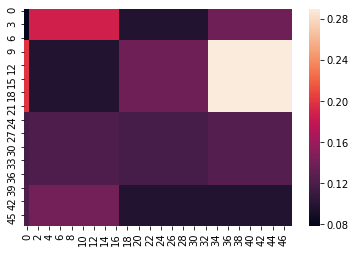

In [174]:
sns.heatmap(probs[0])

In [176]:
for i in os.listdir("../data/test-csv/")[1:2]:
    if ".csv" in i:
        df = pd.read_csv("../data/test-csv/{}".format(i))
        for column in ['IMAGERY_TITLE', 'STACKINGPROFILEDG', 'PL_PLOTID', 'IMAGERYYEARDG']:
            if column in df.columns:
                df = df.drop(column, axis = 1)
        df = df.dropna(axis = 0)
        plot_ids = sorted(df['PLOT_ID'].unique())
        existing = []#[int(x[:-4]) for x in os.listdir("../data/raw/test-shadows/") if ".DS" not in x]
        print(existing)
        to_download = [x for x in plot_ids if x not in existing]
        errors = []
        for i, val in enumerate(to_download[:1]):
            print("Downloading {}/{}, {}".format(i+1, len(to_download), val))
            location = calc_bbox(val, df = df)
            location_clouds = bounding_box(location, expansion = 96*10)
            probs, shadows, _, _ = identify_clouds_new(location_clouds)

[]


KeyboardInterrupt: 

In [ ]:
for i in os.listdir("../data/drylands/csv/"):
    if "fao-test-2.csv" in i:
    #if ".csv" in i:
        #if any(x in i for x in ["africa-west", "cameroon", "koure", "niger"]):
        tile = download_plots("../data/drylands/csv/" + i, "../data/drylands/s2/", image_format = MimeType.TIFF_d16)